## Loading data

In [11]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import pandas as pd

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
# DATA_DIR = "D:/Master/MasterProject/dataset_creation/datasets/FINAL_DATASET_cutout_with_padding/compiled_datasets_medium"
DATA_DIR = "D:/Master/MasterProject/dataset_creation/datasets/FINAL_DATASET_cutout_with_padding/compiled_datasets_16bit_tiny"
# compiled_datasets_medium

In [13]:
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/labels')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/labels')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/labels')

In [14]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [15]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from dataset import Dataset as Dataset2, get_preprocessing
import albumentations as albu
CHANNELS_IN_IMAGE = 1

In [16]:
# class Dataset2(BaseDataset):    
#     CLASSES = ['granule']
    
#     def __init__(
#             self, 
#             images_dir, 
#             masks_dir, 
#             classes=None, 
#             augmentation=None, 
#             preprocessing=None,
#     ):
#         self.ids = os.listdir(images_dir)
#         self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
#         self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
#         # convert str names to class values on masks
#         self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
#         self.augmentation = augmentation
#         self.preprocessing = preprocessing
    
#     def __getitem__(self, i):
        
#         # read data
#         image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
#         assert image.shape == (1024,1024)
#         assert image[524,524] > 260, "Ensure 16bit"
        
#         # image = cv2.imread(self.images_fps[i])
#         # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # <- Read as 1 channel!
#         # print(image.shape)
#         # print(image[524,524])
#         mask = cv2.imread(self.masks_fps[i], 0)
        
#         # extract certain classes from mask (e.g. cars)
#         # masks = [(mask == 215) for v in self.class_values]
#         # mask = np.stack(masks, axis=-1).astype('float')
#         # Convert to binary mask
#         mask[mask == 30]  = 0
#         mask[mask == 215] = 1
#         mask = np.stack([mask], axis=-1).astype('float')
#         # print("Mask shape")
#         # print(mask.shape)
        
#         # apply augmentations
#         if self.augmentation:
#             sample = self.augmentation(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']
        
#         # apply preprocessing
#         if self.preprocessing:
#             sample = self.preprocessing(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']
            
#         return image, mask
        
#     def __len__(self):
#         return len(self.ids)

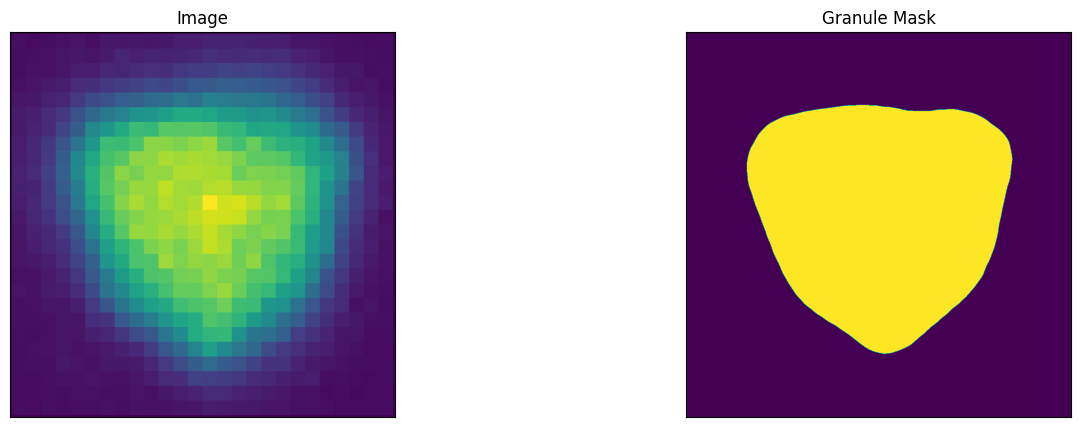

In [17]:
dataset = Dataset2(x_train_dir, y_train_dir, classes=['granule'], CHANNELS_IN_IMAGE=CHANNELS_IN_IMAGE)

image, mask = dataset[23] # get some sample
visualize(
    image=image, 
    granule_mask=mask.squeeze(-1),
)

In [18]:
# def to_tensor(x, **kwargs):
#     # print("dasdasda")
#     # print(x.shape)
#     if x.shape == (1024,1024):
#         # print("---")
#         # print(x.shape)
#         # x = torch.from_numpy(x.astype('float32')).unsqueeze(0).permute(0,1,2)
#         x = np.expand_dims(x, 0).transpose(0,1,2).astype('float32')
#         # print(x.shape)
#         # print("---")
#         return x
#     return x.transpose(2, 0, 1).astype('float32')


# def get_preprocessing(preprocessing_fn):
#     """Construct preprocessing transform
    
#     Args:
#         preprocessing_fn (callbale): data normalization function 
#             (can be specific for each pretrained neural network)
#     Return:
#         transform: albumentations.Compose
    
#     """
    
#     _transform = [
#         # albu.Lambda(image=preprocessing_fn),
#         albu.Lambda(image=to_tensor, mask=to_tensor),
#     ]
#     return albu.Compose(_transform)

---
(1024, 1024)
(1024, 1024, 1)


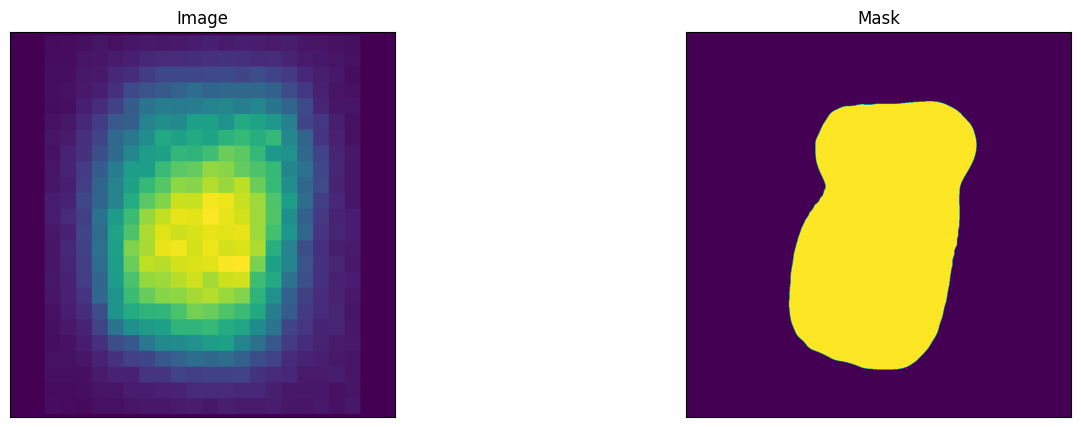

In [19]:
#### Visualize resulted augmented images and masks
augmented_dataset = Dataset2(
    x_train_dir, 
    y_train_dir,  
    # preprocessing=get_preprocessing(None),
    classes=['granule'],
    CHANNELS_IN_IMAGE=CHANNELS_IN_IMAGE
)

# same image with different random transforms
for i in range(1):
    image, mask = augmented_dataset[i]
    print("---")
    print(image.shape)
    print(mask.shape)
    visualize(image=image, mask=mask.squeeze())
    # visualize(image=image, mask=mask.squeeze(-1))
    #torch.Size([1, 1024, 1024])

## Create model and train

In [20]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import IoU, Accuracy, Fscore
from segmentation_models_pytorch.utils.train import TrainEpoch, ValidEpoch
from segmentation_models_pytorch.utils.losses import DiceLoss, BCELoss, MSELoss, JaccardLoss

In [21]:
ENCODER = 'resnet34'#'efficientnet-b0' #'efficientnet-b1'#'resnet101' #'mit_b1' #efficientnet-b0' #'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['granule']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
# model = smp.FPN(
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    in_channels=1
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [22]:
# for p in model.encoder.parameters():
#     p.requires_grad = False

list(model.encoder.children())
# list(model.parameters())
decoder_total_params = sum(p.numel() for p in model.decoder.parameters())
encoder_total_params = sum(p.numel() for p in model.encoder.parameters())
seg_head_total_params = sum(p.numel() for p in model.segmentation_head.parameters())
print(f"{decoder_total_params} + {encoder_total_params} + {seg_head_total_params} = {decoder_total_params+encoder_total_params+seg_head_total_params}")

1152528 + 21278400 + 257 = 22431185


In [23]:
# my_new_image = cv2.imread("D:\Master\MasterProject\dataset_creation\datasets\cutout_with_padding\\all_data\images\\2020-02-05_14.18.49--NAs--T1354-GFP_Burst_Frame_0_Granule_3.png", cv2.IMREAD_COLOR)
# # cv2.imshow('asd', my_new_image)
# # cv2.waitKey(0)
# my_new_image.shape
# my_new_image = torch.from_numpy(my_new_image)
# my_new_image = my_new_image.permute(2, 0, 1) # H W N -> N H W
# my_new_image = my_new_image / 255
# my_new_image = torch.unsqueeze(my_new_image, 0)

# print(my_new_image.shape)
# print(my_new_image[0, 2, 3])

# out = model(my_new_image)
# out.shape

In [24]:
train_dataset = Dataset2(
    x_train_dir, #x_test_dir,#x_train_dir, 
    y_train_dir, #y_test_dir,#, 
    # augmentation=get_training_augmentation(), 
    # preprocessing=get_preprocessing(None),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    CHANNELS_IN_IMAGE=CHANNELS_IN_IMAGE
)

valid_dataset = Dataset2(
    x_valid_dir, 
    y_valid_dir, 
    # augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    # preprocessing=get_preprocessing(None),
    classes=CLASSES,
    CHANNELS_IN_IMAGE=CHANNELS_IN_IMAGE
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0, drop_last=True)

# for i in range(3):
#     image, mask = train_dataset[i]
#     # print(image.shape)
#     visualize(image=image, mask=mask.squeeze(-1))
    # image = image.transpose(1, 2, 0).astype('float32')
    # visualize(image=image, mask=mask[0])

In [25]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

# loss = BCELoss() #DiceLoss() #smp.losses.DiceLoss(mode='binary')#utils.losses.DiceLoss()
loss = JaccardLoss() #DiceLoss() #smp.losses.DiceLoss(mode='binary')#utils.losses.DiceLoss()
metrics = [
    IoU(threshold=0.5), #utils.metrics.IoU(threshold=0.5),
    Accuracy(),
    Fscore()
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [26]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [27]:
df = pd.DataFrame({metric_name._get_name():[] for metric_name in metrics})
df[loss._get_name()] = []
df

df_train = {"train_"+metric_name._get_name():[] for metric_name in metrics}
df_train["train_"+loss._get_name()] = []
df_val = {"val_"+metric_name._get_name():[] for metric_name in metrics}
df_val["val_"+loss._get_name()] = []
df_train.update(df_val)
df = df_train
print(df)

{'train_IoU': [], 'train_Accuracy': [], 'train_Fscore': [], 'train_JaccardLoss': [], 'val_IoU': [], 'val_Accuracy': [], 'val_Fscore': [], 'val_JaccardLoss': []}


In [28]:
def log_training(df:dict, train_logs: dict, validation_logs:dict):
    train_logs = {"train_"+k:v for k,v in train_logs.items()}
    validation_logs = {"val_"+k:v for k,v in validation_logs.items()}
    
    for k,v in train_logs.items():
        df[k].append(v)
    for k,v in validation_logs.items():
        df[k].append(v)
    return df

In [29]:
def create_log_dict(metrics, loss):
    df_train = {"train_"+metric_name.__name__:[] for metric_name in metrics}
    df_train["train_"+loss.__name__] = []
    df_val = {"val_"+metric_name.__name__:[] for metric_name in metrics}
    df_val["val_"+loss.__name__] = []
    df_train.update(df_val)
    return df_train

In [30]:
for x,y in train_loader:
    print(x.shape)
    print(y.shape)
    break
# Should be 
# torch.Size([4, 1, 1024, 1024])
# torch.Size([4, 1, 1024, 1024])

torch.Size([8, 1, 1024, 1024])
torch.Size([8, 1, 1024, 1024])


In [31]:
# train model for 40 epochs

max_score = 0
# Create logging dict

df = create_log_dict(metrics, loss)
print(df)

for i in range(0, 10):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    df = log_training(df, train_logs, valid_logs) # Save stats

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 7:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
# df = pd.DataFrame(df)
# df.to_csv('te.csv')

{'train_iou_score': [], 'train_accuracy': [], 'train_fscore': [], 'train_jaccard_loss': [], 'val_iou_score': [], 'val_accuracy': [], 'val_fscore': [], 'val_jaccard_loss': []}

Epoch: 0
train:   0%|          | 0/87 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
torch.cuda.max_memory_allocated() # 12671343104 - 9704958464
torch.cuda.reset_max_memory_allocated()

## Test best saved model

In [32]:
# load best saved checkpoint
# best_model = torch.load('MODELS/best_model__DeepLabV3Plus__resnet101__DiceLoss__Freeze_encoder_False.pth')
best_model = torch.load('D:/Master/MasterProject/segmentation_models_project/MODELS/best_model__DeepLabV3Plus__resnet34__JaccardLoss__Freeze_encoder_False.pth')
# best_model = torch.load('./best_model.pth')

In [33]:
# create test dataset
test_dataset = Dataset2(
    x_test_dir, 
    y_test_dir, 
    # augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    CHANNELS_IN_IMAGE=CHANNELS_IN_IMAGE
)

test_dataloader = DataLoader(test_dataset)

In [34]:
# # evaluate model on test set
# test_epoch = smp.utils.train.ValidEpoch(
#     model=best_model,
#     loss=loss,
#     metrics=metrics,
#     device=DEVICE,
# )

# logs = test_epoch.run(test_dataloader)

## Visualize predictions

In [35]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset2(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
    CHANNELS_IN_IMAGE=CHANNELS_IN_IMAGE
)

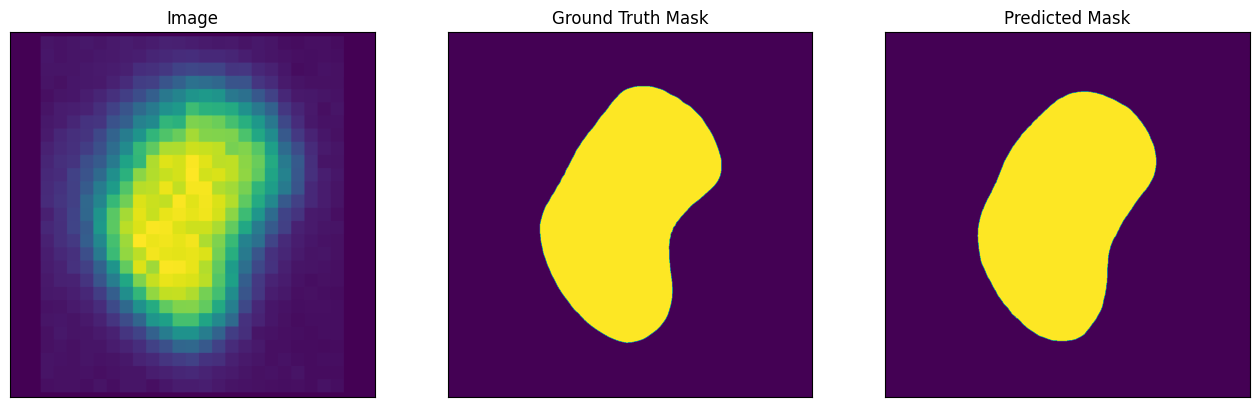

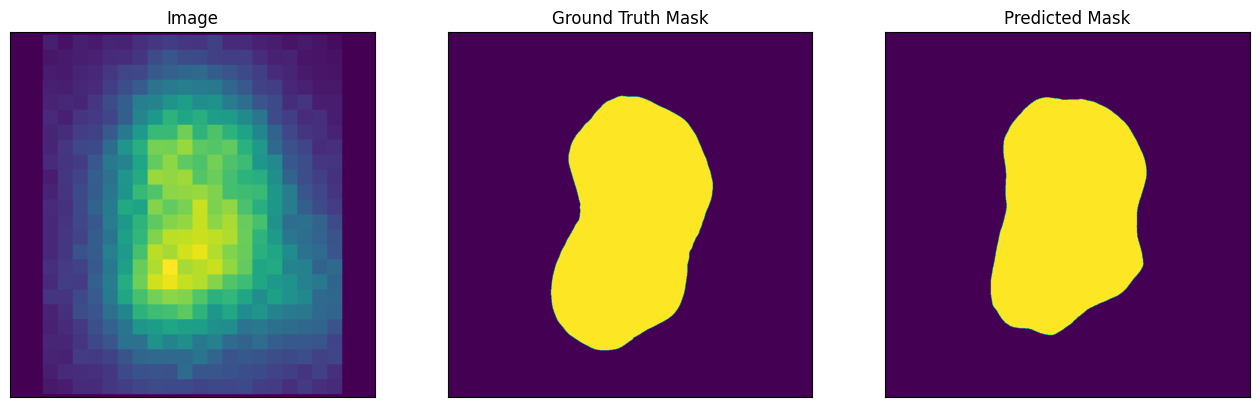

In [39]:
for i in range(2):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0]
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

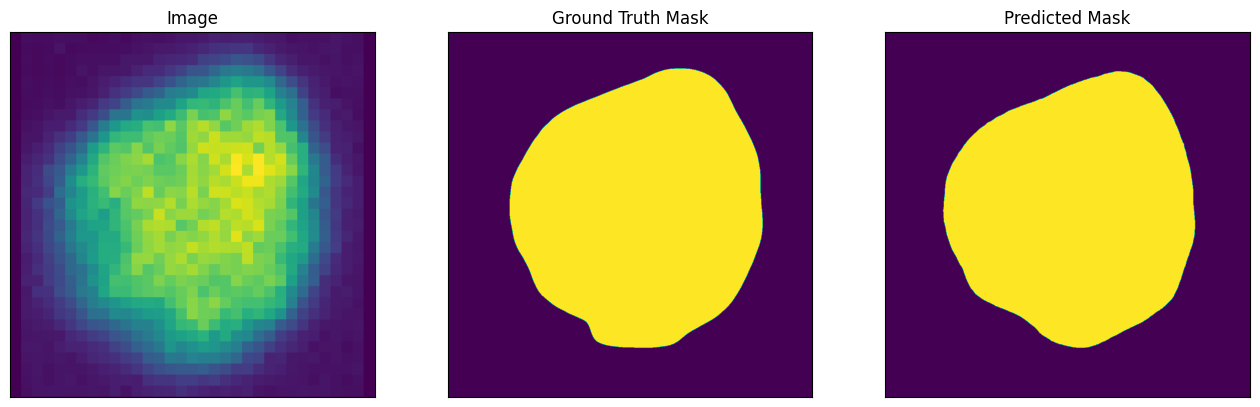

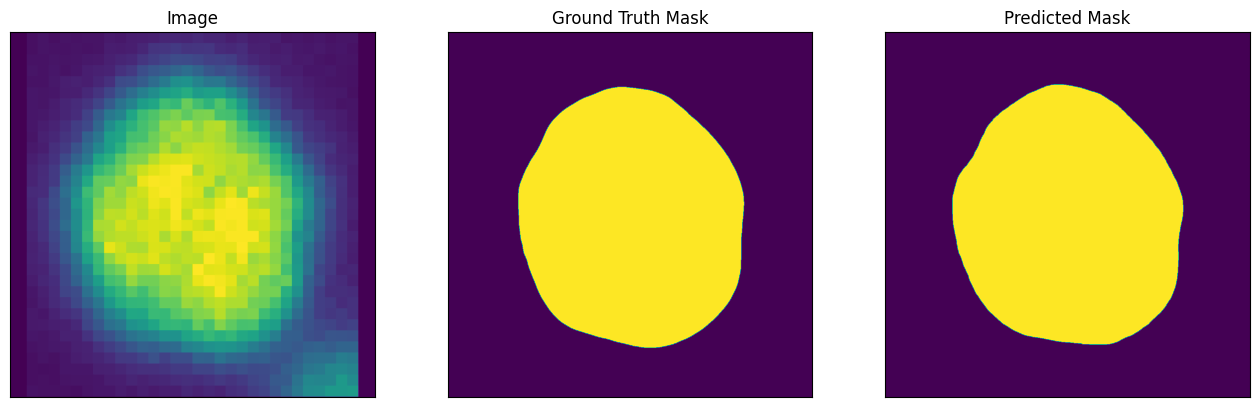

In [37]:
for i in range(2):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0]
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

# Model memory

In [38]:
# # training loop wrapped with profiler object
# with torch.profiler.profile(
#         schedule=torch.profiler.schedule(wait=1, warmup=4, active=3, repeat=1),
#         on_trace_ready=torch.profiler.tensorboard_trace_handler('./example'),
#         record_shapes=True,
#         profile_memory=True,
#         with_stack=True
# ) as prof:
#     for step, data in enumerate(train_loader):
#         inputs = data[0].to(device=device, non_blocking=True)
#         labels = data[1].to(device=device, non_blocking=True)
#         inputs = (inputs.to(torch.float32) / 255. - 0.5) / 0.5
#         if step >= (1 + 4 + 3) * 1:
#             break
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad(set_to_none=True)
#         loss.backward()
#         optimizer.step()
#         prof.step()